# Home 4: Build a seq2seq model for machine translation.

### Name: Erika Deckter

### Task: Translate English to French and Spanish

## 0. You will do the following:

1. Read and run my code.
2. Complete the code in Section 1.1 and Section 4.2.

    * Translation English to **German** is not acceptable!!! Try another language.
    
3. **Make improvements.** Directly modify the code in Section 3. Do at least one of the followings. By doing more, you will get up to 2 bonus scores to the total.

    * Bi-LSTM instead of LSTM
    
    * Multi-task learning (e.g., both English to French and English to Spanish)
    
    * Attention
    
4. Evaluate the translation using the BLEU score. 

    * Optional. Up to 1 bonus scores to the total.
    
5. Convert the notebook to .HTML file. 

    * The HTML file must contain the code and the output after execution.

6. Put the .HTML file in your own Github repo. 

7. Submit the link to the HTML file to Canvas.    


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Hint: 

To implement ```Bi-LSTM```, you will need the following code to build the encoder; the decoder won't be much different.

In [ ]:
from keras.layers import Bidirectional, Concatenate

encoder_bilstm = Bidirectional(LSTM(latent_dim, return_state=True, 
                                  dropout=0.5, name='encoder_lstm'))
_, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_inputs)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

### Hint: 

To implement multi-task training, you can refer to ```Section 7.1.3 Multi-output models``` of the textbook, ```Deep Learning with Python```.

## 1. Data preparation

1. Download data (e.g., "deu-eng.zip") from http://www.manythings.org/anki/
2. Unzip the .ZIP file.
3. Put the .TXT file (e.g., "deu.txt") in the directory "./Data/".

### 1.1. Load and clean text


In [0]:
import re
import string
from unicodedata import normalize
import numpy

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text


# split a loaded document into sentences
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs

def clean_data(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return numpy.array(cleaned)

#### Fill the following blanks:

In [0]:
# e.g., filename = 'Data/deu.txt'
files = ['drive/My Drive/CS 583/data/fra.txt', 'drive/My Drive/CS 583/data/spa.txt']
#files = ['data/fra.txt', 'data/spa.txt']

# e.g., n_train = 20000
n_train = 50000

In [0]:
def get_sentence_pairs(filename):
    # load dataset
    doc = load_doc(filename)
    # split into Language1-Language2 pairs
    pairs = to_pairs(doc)
    # clean sentences
    #clean_pairs = clean_data(pairs)[0:n_train, :]
    clean_pairs = clean_data(pairs)
    
    return clean_pairs

#Get French and Spanish pairs
french_pairs = get_sentence_pairs(files[0])[:,0:2]
spanish_pairs = get_sentence_pairs(files[1])[:,0:2]

In [0]:
#Join two datasets on English phrases
import pandas as pd

french = pd.DataFrame(french_pairs, columns=['English','French'])
spanish = pd.DataFrame(spanish_pairs, columns=['English','Spanish'])
spanish.set_index('English')

#Combine on English words
all_pairs = french.join(spanish.set_index('English'), on='English', how='inner').reset_index(drop=True)

#Pick n_train random sentences to use for training data
pairs = all_pairs.sample(n=n_train, random_state=42)
#Designate remaining data as test dataset
test_pairs = all_pairs.drop(pairs.index)

#Convert training and test dataset to numpy arrays
pairs = numpy.array(pairs)
test_pairs = numpy.array(test_pairs)

In [5]:
#Print French pairs
print('English => French')
for i in range(3000, 3010):
    print('[' + pairs[i, 0] + '] => [' + pairs[i, 1] + ']')
#Print Spanish pairs
print('\nEnglish => Spanish')
for i in range(3000, 3010):
    print('[' + pairs[i, 0] + '] => [' + pairs[i, 2] + ']')

English => French
[why dont you come visit us] => [pourquoi ne venezvous pas nous voir]
[i cant say] => [je ne peux le dire]
[help me] => [aidemoi]
[remain seated please] => [veuillez rester assises]
[i spent a lot of my time studying french] => [jai passe beaucoup de mon temps a etudier le francais]
[is it raining now] => [pleutil maintenant]
[people can turn to the law if they want to correct an injustice] => [les gens peuvent se tourner vers la loi sils veulent corriger une injustice]
[this time ill try it] => [cette fois je vais essayer ca]
[write your full name] => [ecrivez votre nom complet]
[youre very brave] => [vous etes tres courageuses]

English => Spanish
[why dont you come visit us] => [por que no vienen a visitarnos]
[i cant say] => [no puedo decir]
[help me] => [ayudame]
[remain seated please] => [quedense sentados por favor]
[i spent a lot of my time studying french] => [paso mucho tiempo estudiando frances]
[is it raining now] => [ahora esta lloviendo]
[people can turn

In [6]:
input_texts = pairs[:, 0]
french_target_texts = ['\t' + text + '\n' for text in pairs[:, 1]]
spanish_target_texts = ['\t' + text + '\n' for text in pairs[:, 2]]

print('Length of input_texts: ' + str(input_texts.shape[0]))
print('Length of french_target_texts: ' + str(len(french_target_texts)))
print('Length of spanish_target_texts: ' + str(len(spanish_target_texts)))

Length of input_texts: 50000
Length of french_target_texts: 50000
Length of spanish_target_texts: 50000


In [7]:
max_encoder_seq_length = max(len(line) for line in input_texts)
max_fr_decoder_seq_length = max(len(line) for line in french_target_texts)
max_sp_decoder_seq_length = max(len(line) for line in spanish_target_texts)

print('max length of input sentences: %d' % (max_encoder_seq_length))
print('max length of French target sentences: %d' % (max_fr_decoder_seq_length))
print('max length of Spanish target sentences: %d' % (max_sp_decoder_seq_length))

max length of input sentences: 203
max length of French target sentences: 226
max length of Spanish target sentences: 240


**Remark:** To this end, you have two lists of sentences: input_texts and target_texts

## 2. Text processing

### 2.1. Convert texts to sequences

- Input: A list of $n$ sentences (with max length $t$).
- It is represented by a $n\times t$ matrix after the tokenization and zero-padding.

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# encode and pad sequences
def text2sequences(max_len, lines):
    tokenizer = Tokenizer(char_level=True, filters='')
    tokenizer.fit_on_texts(lines)
    seqs = tokenizer.texts_to_sequences(lines)
    seqs_pad = pad_sequences(seqs, maxlen=max_len, padding='post')
    return seqs_pad, tokenizer.word_index


encoder_input_seq, input_token_index = text2sequences(max_encoder_seq_length, 
                                                      input_texts)
fr_decoder_input_seq, fr_target_token_index = text2sequences(max_fr_decoder_seq_length, 
                                                             french_target_texts)
sp_decoder_input_seq, sp_target_token_index = text2sequences(max_sp_decoder_seq_length, 
                                                             spanish_target_texts)

print('shape of encoder_input_seq: ' + str(encoder_input_seq.shape))
print('shape of input_token_index: ' + str(len(input_token_index)))
print('shape of fr_decoder_input_seq: ' + str(fr_decoder_input_seq.shape))
print('shape of fr_target_token_index: ' + str(len(fr_target_token_index)))
print('shape of sp_decoder_input_seq: ' + str(sp_decoder_input_seq.shape))
print('shape of sp_target_token_index: ' + str(len(sp_target_token_index)))

Using TensorFlow backend.


shape of encoder_input_seq: (50000, 203)
shape of input_token_index: 27
shape of fr_decoder_input_seq: (50000, 226)
shape of fr_target_token_index: 29
shape of sp_decoder_input_seq: (50000, 240)
shape of sp_target_token_index: 29


In [9]:
num_encoder_tokens = len(input_token_index) + 1
num_fr_decoder_tokens = len(fr_target_token_index) + 1
num_sp_decoder_tokens = len(sp_target_token_index) + 1

print('num_encoder_tokens: ' + str(num_encoder_tokens))
print('num_fr_decoder_tokens: ' + str(num_fr_decoder_tokens))
print('num_sp_decoder_tokens: ' + str(num_sp_decoder_tokens))

num_encoder_tokens: 28
num_fr_decoder_tokens: 30
num_sp_decoder_tokens: 30


**Remark:** To this end, the input language and target language texts are converted to 2 matrices. 

- Their number of rows are both n_train.
- Their number of columns are respective max_encoder_seq_length and max_decoder_seq_length.

The followings print a sentence and its representation as a sequence.

In [10]:
print('French Target Text: ',repr(french_target_texts[100]))
print('Spanish Target Text: ',repr(spanish_target_texts[100]))

French Target Text:  '\tveuxtu diner avec moi\n'
Spanish Target Text:  '\tte gustaria cenar conmigo\n'


In [11]:
print('French Decoder Sequence')
print(fr_decoder_input_seq[100, :])
print('Spanish Decoder Sequence')
print(sp_decoder_input_seq[100, :])

French Decoder Sequence
[12 18  2  6 26  7  6  1 16  5  8  2  9  1  4 18  2 17  1 15 10  5 13  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]
Spanish Decoder Sequence
[12  9  2  1 22 11  5  9  3  7  8  3  1 15  2  6  3  7  1 15  4  6 16  8
 22  4 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## 2.2. One-hot encode

- Input: A list of $n$ sentences (with max length $t$).
- It is represented by a $n\times t$ matrix after the tokenization and zero-padding.
- It is represented by a $n\times t \times v$ tensor ($t$ is the number of unique chars) after the one-hot encoding.

In [12]:
from keras.utils import to_categorical

# one hot encode target sequence
def onehot_encode(sequences, max_len, vocab_size):
    n = len(sequences)
    data = numpy.zeros((n, max_len, vocab_size))
    for i in range(n):
        data[i, :, :] = to_categorical(sequences[i], num_classes=vocab_size)
    return data

encoder_input_data = onehot_encode(encoder_input_seq, max_encoder_seq_length, num_encoder_tokens)
fr_decoder_input_data = onehot_encode(fr_decoder_input_seq, max_fr_decoder_seq_length, num_fr_decoder_tokens)
sp_decoder_input_data = onehot_encode(sp_decoder_input_seq, max_sp_decoder_seq_length, num_sp_decoder_tokens)

fr_decoder_target_seq = numpy.zeros(fr_decoder_input_seq.shape)
fr_decoder_target_seq[:, 0:-1] = fr_decoder_input_seq[:, 1:]
fr_decoder_target_data = onehot_encode(fr_decoder_target_seq, 
                                       max_fr_decoder_seq_length, 
                                       num_fr_decoder_tokens)
sp_decoder_target_seq = numpy.zeros(sp_decoder_input_seq.shape)
sp_decoder_target_seq[:, 0:-1] = sp_decoder_input_seq[:, 1:]
sp_decoder_target_data = onehot_encode(sp_decoder_target_seq, 
                                       max_sp_decoder_seq_length, 
                                       num_sp_decoder_tokens)

print(encoder_input_data.shape)
print(fr_decoder_input_data.shape)
print(sp_decoder_input_data.shape)

(50000, 203, 28)
(50000, 226, 30)
(50000, 240, 30)


## 3. Build the networks (for training)

- Build encoder, decoder, and connect the two modules to get "model". 

- Fit the model on the bilingual data to train the parameters in the encoder and decoder.

### 3.1. Encoder network

- Input:  one-hot encode of the input language

- Return: 

    -- output (all the hidden states   $h_1, \cdots , h_t$) are always discarded
    
    -- the final hidden state  $h_t$
    
    -- the final conveyor belt $c_t$

In [13]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Concatenate
from tensorflow.keras.models import Model

latent_dim = 256

# inputs of the encoder network
encoder_inputs = Input(shape=(None, num_encoder_tokens), 
                       name='encoder_inputs')

# set the LSTM layer
encoder_bilstm = Bidirectional(LSTM(latent_dim, return_state=True, 
                    dropout=0.5, name='encoder_bilstm'))
_, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_inputs)

#Concatenate forward and backward states
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# build the encoder network model
encoder_model = Model(inputs=encoder_inputs, 
                      outputs=[state_h, state_c],
                      name='encoder')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Print a summary and save the encoder network structure to "./encoder.jpg"   
Note: I changed file extension to .jpg (from .pdf) because the pdf was causing an error in Jupyter.

In [14]:
from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot, plot_model
from tensorflow.keras.utils import model_to_dot, plot_model

SVG(model_to_dot(encoder_model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=encoder_model, show_shapes=False,
    to_file='encoder.jpg' #Changed file extension to .jpg (from .pdf) because the pdf was causing an error in Jupyter
)

encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None, 28)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 512), (None, 583680      encoder_inputs[0][0]             
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional[0][2]        

### 3.2. Decoder network

- Inputs:  

    -- one-hot encode of the target language
    
    -- The initial hidden state $h_t$ 
    
    -- The initial conveyor belt $c_t$ 

- Return: 

    -- output (all the hidden states) $h_1, \cdots , h_t$

    -- the final hidden state  $h_t$ (discarded in the training and used in the prediction)
    
    -- the final conveyor belt $c_t$ (discarded in the training and used in the prediction)

In [0]:
#French Decoder
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate
from tensorflow.keras.models import Model

# inputs of the decoder network
decoder_input_h = Input(shape=(2*latent_dim,), name='decoder_input_h')
decoder_input_c = Input(shape=(2*latent_dim,), name='decoder_input_c')
decoder_input_fr = Input(shape=(None, num_fr_decoder_tokens), name='decoder_input_fr')

# set the LSTM layer
fr_decoder_lstm = LSTM(2*latent_dim, return_sequences=True, 
                                  return_state=True, dropout=0.5, name='fr_decoder_lstm')
fr_decoder_lstm_outputs, state_h, state_c = fr_decoder_lstm(decoder_input_fr, 
                                                     initial_state=[decoder_input_h, decoder_input_c])

# set the dense layer
fr_decoder_dense = Dense(num_fr_decoder_tokens, activation='softmax', name='fr_decoder_dense')
fr_decoder_outputs = fr_decoder_dense(fr_decoder_lstm_outputs)

# build the decoder network model
fr_decoder_model = Model(inputs=[decoder_input_fr, decoder_input_h, decoder_input_c],
                      outputs=[fr_decoder_outputs, state_h, state_c],
                      name='fr_decoder')

Print a summary and save the encoder network structure to "./decoder.jpg"

In [16]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

SVG(model_to_dot(fr_decoder_model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=fr_decoder_model, show_shapes=False,
    to_file='fr_decoder.jpg'
)

fr_decoder_model.summary()

Model: "fr_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_fr (InputLayer)   [(None, None, 30)]   0                                            
__________________________________________________________________________________________________
decoder_input_h (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
decoder_input_c (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
fr_decoder_lstm (LSTM)          [(None, None, 512),  1112064     decoder_input_fr[0][0]           
                                                                 decoder_input_h[0][0]   

In [0]:
#Spanish Decoder
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate
from tensorflow.keras.models import Model

# inputs of the decoder network
decoder_input_h = Input(shape=(2*latent_dim,), name='decoder_input_h')
decoder_input_c = Input(shape=(2*latent_dim,), name='decoder_input_c')
decoder_input_sp = Input(shape=(None, num_sp_decoder_tokens), name='decoder_input_sp')

# set the LSTM layer
sp_decoder_lstm = LSTM(2*latent_dim, return_sequences=True, 
                    return_state=True, dropout=0.5, name='sp_decoder_lstm')
sp_decoder_lstm_outputs, state_h, state_c = sp_decoder_lstm(decoder_input_sp, 
                                                      initial_state=[decoder_input_h, decoder_input_c])

# set the dense layer
sp_decoder_dense = Dense(num_sp_decoder_tokens, activation='softmax', name='sp_decoder_dense')
sp_decoder_outputs = sp_decoder_dense(sp_decoder_lstm_outputs)

# build the decoder network model
sp_decoder_model = Model(inputs=[decoder_input_sp, decoder_input_h, decoder_input_c],
                      outputs=[sp_decoder_outputs, state_h, state_c],
                      name='sp_decoder')

Print a summary and save the encoder network structure to "./decoder.jpg"

In [18]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

SVG(model_to_dot(sp_decoder_model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sp_decoder_model, show_shapes=False,
    to_file='sp_decoder.jpg'
)

sp_decoder_model.summary()

Model: "sp_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_sp (InputLayer)   [(None, None, 30)]   0                                            
__________________________________________________________________________________________________
decoder_input_h (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
decoder_input_c (InputLayer)    [(None, 512)]        0                                            
__________________________________________________________________________________________________
sp_decoder_lstm (LSTM)          [(None, None, 512),  1112064     decoder_input_sp[0][0]           
                                                                 decoder_input_h[0][0]   

### 3.3. Connect the encoder and decoder

In [0]:
# input layers
encoder_input_x = Input(shape=(None, num_encoder_tokens), name='encoder_input_x')
decoder_input_fr = Input(shape=(None, num_fr_decoder_tokens), name='decoder_input_fr')
decoder_input_sp = Input(shape=(None, num_sp_decoder_tokens), name='decoder_input_sp')

# connect encoder to decoder
encoder_final_states = encoder_model(encoder_input_x)
fr_decoder_lstm_output, _, _ = fr_decoder_lstm(decoder_input_fr, initial_state=encoder_final_states)
fr_decoder_pred = fr_decoder_dense(fr_decoder_lstm_output)
sp_decoder_lstm_output, _, _ = sp_decoder_lstm(decoder_input_sp, initial_state=encoder_final_states)
sp_decoder_pred = sp_decoder_dense(sp_decoder_lstm_output)

model = Model(inputs=[encoder_input_x, decoder_input_fr, decoder_input_sp], 
              outputs=[fr_decoder_pred, sp_decoder_pred], 
              name='model_training')

In [20]:
print(state_h)
print(decoder_input_h)

Tensor("sp_decoder_lstm/while/Exit_2:0", shape=(?, 512), dtype=float32)
Tensor("decoder_input_h_1:0", shape=(?, 512), dtype=float32)


In [21]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

SVG(model_to_dot(model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=model, show_shapes=False,
    to_file='model_training.jpg'
)

model.summary()

Model: "model_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    [(None, None, 28)]   0                                            
__________________________________________________________________________________________________
decoder_input_fr (InputLayer)   [(None, None, 30)]   0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 512), (None, 583680      encoder_input_x[0][0]            
__________________________________________________________________________________________________
decoder_input_sp (InputLayer)   [(None, None, 30)]   0                                            
_____________________________________________________________________________________

### 3.5. Fit the model on the bilingual dataset

- encoder_input_data: one-hot encode of the input language

- decoder_input_data: one-hot encode of the input language

- decoder_target_data: labels (left shift of decoder_input_data)

- tune the hyper-parameters

- stop when the validation loss stop decreasing.

In [22]:
print('shape of encoder_input_data' + str(encoder_input_data.shape))
print('shape of fr_decoder_input_data' + str(fr_decoder_input_data.shape))
print('shape of fr_decoder_target_data' + str(fr_decoder_target_data.shape))
print('shape of sp_decoder_input_data' + str(sp_decoder_input_data.shape))
print('shape of sp_decoder_target_data' + str(sp_decoder_target_data.shape))

shape of encoder_input_data(50000, 203, 28)
shape of fr_decoder_input_data(50000, 226, 30)
shape of fr_decoder_target_data(50000, 226, 30)
shape of sp_decoder_input_data(50000, 240, 30)
shape of sp_decoder_target_data(50000, 240, 30)


In [0]:
#Add model callbacks to allow for early stopping
from keras import callbacks

model_callbacks = [callbacks.EarlyStopping(monitor='loss', patience=1),
                   callbacks.ModelCheckpoint(filepath='drive/My Drive/CS 583/seq2seq.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [24]:
Compile and train model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit([encoder_input_data, fr_decoder_input_data, sp_decoder_input_data],  # training data
                    [fr_decoder_target_data, sp_decoder_target_data],                    # labels (left shift of the target sequences)
                    batch_size=64, callbacks = model_callbacks,
                    epochs=50, validation_split=0.2)

model.save('drive/My Drive/CS 583/seq2seq.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 969s 24ms/sample - loss: 0.8034 - fr_decoder_dense_loss: 0.4323 - sp_decoder_dense_loss: 0.3712 - fr_decoder_dense_acc: 0.8857 - sp_decoder_dense_acc: 0.9010 - val_loss: 0.5365 - val_fr_decoder_dense_loss: 0.2871 - val_sp_decoder_dense_loss: 0.2495 - val_fr_decoder_dense_acc: 0.9114 - val_sp_decoder_dense_acc: 0.9211
Epoch 2/50
40000/40000 [==============================] - 958s 24ms/sample - loss: 0.5392 - fr_decoder_dense_loss: 0.2885 - sp_decoder_dense_loss: 0.2506 - fr_decoder_dense_acc: 0.9118 - sp_decoder_dense_acc: 0.9218 - val_loss: 0.4554 - val_fr_decoder_dense_loss: 0.2415 - val_sp_decoder_dense_loss: 0.2136 - val_fr_decoder_dense_acc: 0.9246 - val_sp_decoder_dense_acc: 0.9312
Epoch 3/50
40000/40000 [==============================] - 962s 24ms/sample - loss: 0.4660 - fr_decoder

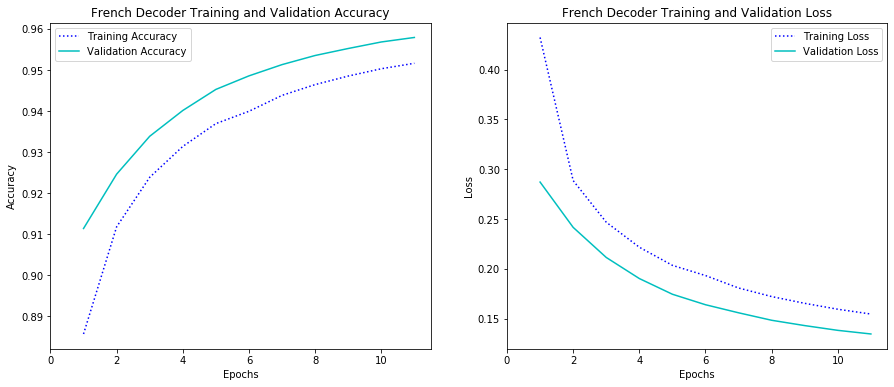

In [25]:
import matplotlib.pyplot as plt

#Plot accuracy and loss for French decoder
fr_acc = history.history['fr_decoder_dense_acc']
fr_val_acc = history.history['val_fr_decoder_dense_acc']
fr_loss = history.history['fr_decoder_dense_loss']
fr_val_loss = history.history['val_fr_decoder_dense_loss']

fr_epochs = range(1,len(fr_acc)+1)

fig = plt.figure(figsize=(15,6))
fig.add_subplot(1,2,1)
plt.plot(fr_epochs, fr_acc, 'b:', label='Training Accuracy')
plt.plot(fr_epochs, fr_val_acc, 'c-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(numpy.arange(0,len(fr_acc)+1,step=2))
plt.title('French Decoder Training and Validation Accuracy')
plt.legend()
fig.add_subplot(1,2,2)            
plt.plot(fr_epochs, fr_loss, 'b:', label='Training Loss')
plt.plot(fr_epochs, fr_val_loss, 'c-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(numpy.arange(0,len(fr_acc)+1,step=2))
plt.title('French Decoder Training and Validation Loss')
plt.legend()
plt.show()

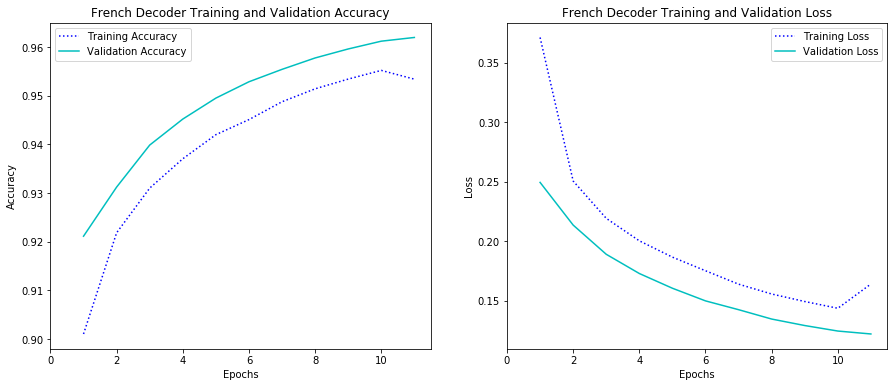

In [34]:
#Plot accuracy and loss for Spanish decoder
sp_acc = history.history['sp_decoder_dense_acc']
sp_val_acc = history.history['val_sp_decoder_dense_acc']
sp_loss = history.history['sp_decoder_dense_loss']
sp_val_loss = history.history['val_sp_decoder_dense_loss']

sp_epochs = range(1,len(sp_acc)+1)

fig = plt.figure(figsize=(15,6))
fig.add_subplot(1,2,1)
plt.plot(sp_epochs, sp_acc, 'b:', label='Training Accuracy')
plt.plot(sp_epochs, sp_val_acc, 'c-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(numpy.arange(0,len(sp_acc)+1,step=2))
plt.title('French Decoder Training and Validation Accuracy')
plt.legend()
fig.add_subplot(1,2,2)            
plt.plot(sp_epochs, sp_loss, 'b:', label='Training Loss')
plt.plot(sp_epochs, sp_val_loss, 'c-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(numpy.arange(0,len(sp_acc)+1,step=2))
plt.title('French Decoder Training and Validation Loss')
plt.legend()
plt.show()

## 4. Make predictions


### 4.1. Translate English to French and Spanish

1. Encoder read a sentence (source language) and output its final states, $h_t$ and $c_t$.
2. Take the [star] sign "\t" and the final state $h_t$ and $c_t$ as input and run the decoder.
3. Get the new states and predicted probability distribution.
4. sample a char from the predicted probability distribution
5. take the sampled char and the new states as input and repeat the process (stop if reach the [stop] sign "\n").

In [0]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_fr_target_char_index = dict((i, char) for char, i in fr_target_token_index.items())
reverse_sp_target_char_index = dict((i, char) for char, i in sp_target_token_index.items())

In [0]:
def decode_french_sequence(input_seq, temp=1.0):
    states_value = encoder_model.predict(input_seq)

    target_seq = numpy.zeros((1, 1, num_fr_decoder_tokens))
    target_seq[0, 0, fr_target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = fr_decoder_model.predict([target_seq] + states_value)

        # this line of code is greedy selection
        # try to use multinomial sampling instead (with temperature)
        #sampled_token_index = numpy.argmax(output_tokens[0, -1, :])
                
        #Choose next character using multinomial sampling with temperature
        probabilities = output_tokens[0, -1, :]
        probs = [p**(1/temp) for p in probabilities]
        probs = probs/numpy.sum(probs)
        probs = numpy.random.multinomial(1, probs, 1)
        sampled_token_index = numpy.argmax(probs)
        sampled_char = reverse_fr_target_char_index.get(sampled_token_index)
        
        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fr_decoder_seq_length):
            stop_condition = True

        target_seq = numpy.zeros((1, 1, num_fr_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [0]:
def decode_spanish_sequence(input_seq, temp=1.0):
    states_value = encoder_model.predict(input_seq)

    target_seq = numpy.zeros((1, 1, num_sp_decoder_tokens))
    target_seq[0, 0, fr_target_token_index['\t']] = 1.

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = sp_decoder_model.predict([target_seq] + states_value)

        # this line of code is greedy selection
        # try to use multinomial sampling instead (with temperature)
        #sampled_token_index = numpy.argmax(output_tokens[0, -1, :])

        #Choose next character using multinomial sampling with temperature
        probabilities = output_tokens[0, -1, :]
        probs = [p**(1/temp) for p in probabilities]
        probs = probs/numpy.sum(probs)
        probs = numpy.random.multinomial(1, probs, 1)
        sampled_token_index = numpy.argmax(probs)
        sampled_char = reverse_sp_target_char_index.get(sampled_token_index)

        decoded_sentence += sampled_char

        if (sampled_char == '\n' or
          len(decoded_sentence) > max_sp_decoder_seq_length):
          stop_condition = True

        target_seq = numpy.zeros((1, 1, num_sp_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        states_value = [h, c]

    return decoded_sentence

In [30]:
for seq_index in range(2100, 2120):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    french_decoded_sentence = decode_french_sequence(input_seq, temp=0.5)
    spanish_decoded_sentence = decode_spanish_sequence(input_seq, temp=0.5)
    print('-')
    print('English:       ', input_texts[seq_index])
    print('French (true): ', french_target_texts[seq_index][1:-1])
    print('French (pred): ', french_decoded_sentence[0:-1])
    print('Spanish (true): ', spanish_target_texts[seq_index][1:-1])
    print('Spanish (pred): ', spanish_decoded_sentence[0:-1])

-
English:        i was incredibly bored
French (true):  je me suis incroyablement ennuye
French (pred):  jetais presque tres fort
Spanish (true):  estaba increiblemente aburrida
Spanish (pred):  estaba abarrondendo a tiempo
-
English:        are you speaking to me
French (true):  me parlezvous
French (pred):  estu en train de te mentrer
Spanish (true):  estas hablando conmigo
Spanish (pred):  estas losotro de eso
-
English:        tom couldnt forget mary even if he wanted to
French (true):  quil le veuille ou non tom ne pourrait pas oublier marie
French (pred):  tom na pas vu de ce que le frord a la ssente par le main
Spanish (true):  tom no podria olvidar a mary aunque quisiera
Spanish (pred):  tom no se pade a visitar a mi padre
-
English:        he proceeded to the next question
French (true):  il passa a la question suivante
French (pred):  il a encore dans la vie est en train de prendre des cattes
Spanish (true):  paso a la siguiente pregunta
Spanish (pred):  el parece con la esc

### 4.2. Translate an English sentence to the target language

1. Tokenization
2. One-hot encode
3. Translate

In [31]:
input_sentence = 'why is that'

#Tokenize to individual characters
tokens = [char for char in input_sentence]
#Convert tokens to integer indices based on input (English) word_index dictionary
input_sequence = [input_token_index.get(token) for token in tokens]
#Convert to numpy array and reshape
input_sequence = numpy.array(input_sequence).reshape((1,len(input_sequence)))
#Pad sequence with zeroes
seqs_pad = pad_sequences(input_sequence, maxlen=max_encoder_seq_length, padding='post')
#Do one-hot encoding
input_x = onehot_encode(seqs_pad, max_encoder_seq_length, num_encoder_tokens)

#Translate English sentence
fr_translated_sentence = decode_french_sequence(input_x, temp=0.5)
sp_translated_sentence = decode_spanish_sequence(input_x, temp=0.5)

#Print original sentence and translations
print('source sentence is: ' + input_sentence)
print('French translated sentence is: ' + fr_translated_sentence[:-1])
print('Spanish translated sentence is: ' + sp_translated_sentence[:-1])

source sentence is: why is that
French translated sentence is: pourquoi cette haute
Spanish translated sentence is: por que esta tom


## 5. Evaluate the translation using BLEU score

Reference: 
- https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
- https://en.wikipedia.org/wiki/BLEU


**Hint:** 

- Randomly partition the dataset to training, validation, and test. 

- Evaluate the BLEU score using the test set. Report the average.

- A reasonable BLEU score should be 0.1 ~ 0.3.

In [59]:
##Calculate average BLEU score on test pairs
from nltk.translate.bleu_score import sentence_bleu
#BLEU score for French and Spanish translations

#Format English sentences to be used to predict translations
#Select random 2000 sentence pairs from test set (so this code will run in a reasonable amount of time)
num_sentences = 2000
random_indices = numpy.random.choice(test_pairs.shape[0], num_sentences, replace=False)
input_sentence = test_pairs[random_indices,0]
#Tokenize to individual characters
tokens = [[char for char in sentence] for sentence in input_sentence]
#Convert tokens to integer indices based on input (English) word_index dictionary
input_sequence = numpy.array([[input_token_index.get(t) for t in token] for token in tokens])
#Pad sequence with zeroes
seqs_pad = pad_sequences(input_sequence, maxlen=max_encoder_seq_length, padding='post')
#Do one-hot encoding
input_x = onehot_encode(seqs_pad, max_encoder_seq_length, num_encoder_tokens)

#Tokenize French and Spanish reference sentences
french_references = test_pairs[random_indices,1]
french_tokens = [french.split(' ') for french in french_references]
spanish_references = test_pairs[random_indices,2]
spanish_tokens = [spanish.split(' ') for spanish in spanish_references]

#Predict translation from English sentence
scores = numpy.zeros((num_sentences,2))
print('Show Translations and BLEU Scores Every 200 Sentence Pairs')
for i, english in enumerate(input_x):
  english = english.reshape(1,*english.shape)
  #Get reference sentence from test set
  french_reference = french_references[i] #Actual French sentence
  spanish_reference = spanish_references[i] #Actual Spanish sentence

  #Predict translation from English sentence
  #Translate to French and Spanish
  french_translation = decode_french_sequence(english, temp=0.2)[:-1]
  french_candidate = french_translation.split(' ') 
  spanish_translation = decode_spanish_sequence(english, temp=0.2)[:-1]
  spanish_candidate = spanish_translation.split(' ') 

  #Calculate BLEU scores
  french_bleu = sentence_bleu(french_tokens[i], french_candidate)
  spanish_bleu = sentence_bleu(spanish_tokens[i], spanish_candidate)
  
  #Print every 200th sentence and BLEU score
  if i%200==0:
    print('English Sentence: {}'.format(input_sentence[i]))
    print('French Reference: {}; French Translation: {}'.format(french_reference, french_translation))
    print('Spanish Reference: {}; Spanish Translation: {}'.format(spanish_reference, spanish_translation))
    print('French BLEU Score: {:.2f}; Spanish BLEU Score: {:.2f}\n'.format(french_bleu, spanish_bleu))
  
  scores[i,:] = [french_bleu, spanish_bleu]

#Calculate average BLEU score by language
mean_scores = numpy.mean(scores, axis=0)
print('Average French  Translation BLEU Score: {:.2f}'.format(mean_scores[0]))
print('Average Spanish Translation BLEU Score: {:.2f}'.format(mean_scores[1]))

Show Translations and BLEU Scores Every 200 Sentence Pairs
English Sentence: please send me your latest catalogue
French Reference: sil vous plait pouvezvous menvoyer votre dernier catalogue; French Translation: veuillez rester ton pere est le plus grand
Spanish Reference: por favor envieme su ultimo catalogo; Spanish Translation: por favor deja que esta es mi pasable
French BLEU Score: 0.00; Spanish BLEU Score: 0.00



/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


English Sentence: she went with him to the zoo
French Reference: elle est allee au zoo avec lui; French Translation: elle le sert dans la porte
Spanish Reference: ella se fue con el al zoologico; Spanish Translation: ella no le dijo que el se lo ayudo
French BLEU Score: 0.00; Spanish BLEU Score: 0.00

English Sentence: bring it here
French Reference: apportele ici; French Translation: essayez ce
Spanish Reference: traelo aqui; Spanish Translation: creerla esto
French BLEU Score: 0.00; Spanish BLEU Score: 0.00

English Sentence: youd better start now
French Reference: tu ferais mieux de commencer maintenant; French Translation: tu me reppelles tout ce que je te connaisse
Spanish Reference: mejor empiezas ya; Spanish Translation: me pasaste esto en la casa
French BLEU Score: 0.00; Spanish BLEU Score: 0.00

English Sentence: youre my enemy
French Reference: vous etes mon ennemi; French Translation: vous etes mon ennemi
Spanish Reference: tu eres mi enemiga; Spanish Translation: eres mi ma